# RZ's project - San Francisco bay area city segmention

## Part1. web page table scraping to acquire city list

In [73]:
#!pip install beautifulsoup4

In [74]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim

In [75]:
req = requests.get('https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_the_San_Francisco_Bay_Area')
page = req.text
soup = BeautifulSoup(page, 'html.parser')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of cities and towns in the San Francisco Bay Area - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"ca021379-e1d9-49a0-b1fc-bc876e8cb1b5","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_cities_and_towns_in_the_San_Francisco_Bay_Area","wgTitle":"List of cities and towns in the San Francisco Bay Area","wgCurRevisionId":966250823,"wgRevisionId":966250823,"wgArticleId":9823327,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Featured lists","Lists of ci

In [76]:
# get all the tables from web page
soup.find_all('table')#[1]#['class']
#[t['class'] for t in soup.find_all('table') if t.get('class')]
# eyeball the class peoperties of tables, and locate the target table that have all the city names
table_html = str(soup.find('table','wikitable plainrowheaders sortable'))
from IPython.core.display import HTML
HTML(table_html)

In [77]:
# get each row from the target table, and show the first rows of the city table
rows = [row for row in soup.find('table','wikitable plainrowheaders sortable').find_all('tr')]
rows[0:3]

[<tr>
 <th rowspan="2" scope="col" style="width:150px;">Name
 </th>
 <th rowspan="2" scope="col" style="width:90px;">Type
 </th>
 <th rowspan="2" scope="col" style="width:140px;">County
 </th>
 <th rowspan="2" scope="col" style="width:110px;">Population (2010)<sup class="reference" id="cite_ref-Census_2010_8-1"><a href="#cite_note-Census_2010-8">[8]</a></sup><sup class="reference" id="cite_ref-CA_Finance_9-0"><a href="#cite_note-CA_Finance-9">[9]</a></sup>
 </th>
 <th colspan="2" scope="col" style="width:170px;">Land area<sup class="reference" id="cite_ref-Census_2010_8-2"><a href="#cite_note-Census_2010-8">[8]</a></sup>
 </th>
 <th rowspan="2" scope="col" style="width:130px;">Incorporated<sup class="reference" id="cite_ref-incorporation_7-1"><a href="#cite_note-incorporation-7">[7]</a></sup>
 </th></tr>, <tr>
 <th>sq mi
 </th>
 <th>km<sup>2</sup>
 </th></tr>, <tr>
 <th scope="row"><a href="/wiki/Alameda,_California" title="Alameda, California">Alameda</a>
 </th>
 <td>City
 </td>
 <td>

scrape all the cities from the first column of the table:

In [78]:
# define a lambada function to strip out the strings from each row or cell:
rem_nl = lambda s: s.replace('\n', '').strip()

In [79]:
# demonstates how the city name is scraped from the first column
[rem_nl(col.get_text()) for col in rows[3].find_all("th") if col.get_text()]

['Albany']

In [80]:
# get a list of all cells from row2 and after from the table:
cities = [rem_nl(value.get_text()) for row in rows[2:] for value in row.find_all("th")]
#print('There are {} cities in San Francisco bay area.'.format(len(cities)))
#cities

## Step 2: use geocoder method to get latitude/longitude for each city

In [81]:
# Nominatim method
from geopy.geocoders import Nominatim
#address = '{}, Toronto, Ontario'.format('M1B')
address = 'San Francisco, San Francisco, CA, USA'
geolocator = Nominatim(user_agent="bayarea_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate are {}, {}.'.format(latitude, longitude))

The geograpical coordinate are 37.7790262, -122.4199061.


In [82]:
import pandas as pd
from geopy.geocoders import Nominatim
column_names = ['City', 'Latitude', 'Longitude']
df_city = pd.DataFrame(columns = column_names)
for city in cities:
 
    #check out lat and lon for each neighborhood:
    address = city + ', CA, USA'
    #print(address)
    geolocator = Nominatim(user_agent = 'bayarea_explore')
    location = geolocator.geocode(address)
    city_lat = location.latitude if location else 'NA'
    city_lon = location.longitude if location else 'NA'
    
    df_city = df_city.append({'City': city,
                         'Latitude': city_lat,
                         'Longitude': city_lon}, ignore_index=True)
# drop row where latitude or longitude is "NA"
df_city.drop(df_city.index[(df_city['Latitude']=='NA') | (df_city['Longitude']=='NA')],inplace=True)
#neighborhoods
#print(len(neighborhoods['Neighborhood'].unique()))

C:\Users\PC\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [83]:
df_city.head()

,City,Latitude,Longitude
0,Alameda,37.609029,-121.899142
1,Albany,37.886870,-122.297747
2,American Canyon,38.223457,-122.227043
3,Antioch,38.004921,-121.805789
4,Atherton,37.461327,-122.197743


## Step 3: Use Foursquare API to acquire venue data for each city, and build a dataframe including at least city, its latitude and longitude, venue name and its category type

Prepare Foursquare request:

In [1]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [85]:
radius=500
LIMIT=100
lat=37.609029
lng=-121.899142
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
results = requests.get(url).json()["response"]['groups'][0]['items']

In [86]:
# create a function to repeat the process acquiring venues:
# radius - define Foursquare API explore radius
# LIMIT - limit of number of venues returned by Foursquare API
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    timer=0
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #if results:
            #timer+=1
            #print(timer, 'done')       
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [87]:
city_venues = getNearbyVenues(names=df_city['City'],
                             latitudes=df_city['Latitude'],
                             longitudes=df_city['Longitude']
                            )

In [88]:
print(city_venues.shape)
city_venues
city_venues.to_csv (r'city_venues.csv', index = False, header=True)

(3136, 7)


In [89]:
city_venues[city_venues['City']=='Oakland']

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1628,Oakland,37.804456,-122.271356,Oaklandish,37.805075,-122.270726,Clothing Store
1629,Oakland,37.804456,-122.271356,Golden Lotus Vegetarian Restaurant,37.803290,-122.270473,Vegetarian / Vegan Restaurant
1630,Oakland,37.804456,-122.271356,Cafe Van Kleef,37.806660,-122.270273,Bar
1631,Oakland,37.804456,-122.271356,Cape & Cowl,37.806725,-122.272747,Comic Shop
1632,Oakland,37.804456,-122.271356,Woods Bar & Brewery,37.806889,-122.270415,Brewery
1633,Oakland,37.804456,-122.271356,Bar Shiru,37.806378,-122.270393,Bar
1634,Oakland,37.804456,-122.271356,The Hatch,37.805006,-122.269584,Bar
1635,Oakland,37.804456,-122.271356,Ume Yoga,37.805493,-122.270945,Yoga Studio
1636,Oakland,37.804456,-122.271356,Nature Vegetarian Restaurant,37.802157,-122.270983,Vegetarian / Vegan Restaurant
1637,Oakland,37.804456,-122.271356,Beauty’s Bagel Shop,37.806082,-122.268356,Bagel Shop


In [90]:
#city_venues.groupby('Neighborhood').count()
'City' in city_venues['Venue Category']
len(city_venues['Venue Category'].unique())
#len(city_venues['City'].unique())

314

## Step 4: <mark>onehot</mark> venue type, and group by neighborhood 

In [91]:
# on hot encoding
city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix='', prefix_sep='')

# add neighborhood column back to dataframe, but change the column name to neighborhoodname
# as neighborhood is one of the venue categories
city_onehot['City'] = city_venues['City']

#move neighborhoodname column to the first column
fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
city_onehot = city_onehot[fixed_columns]

city_onehot.head()

,City,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,...,Vietnamese Restaurant,Vineyard,Waterfront,Weight Loss Center,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Albany,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Albany,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Albany,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Albany,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Albany,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
# group rows by city and by taking the mean of the frequency of 
# occurrence of each category
city_grouped = city_onehot.groupby('City').mean().reset_index()
city_grouped

,City,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,...,Vietnamese Restaurant,Vineyard,Waterfront,Weight Loss Center,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Albany,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000
1,American Canyon,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2,Antioch,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Atherton,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Belmont,0.015873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.015873,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Belvedere,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Benicia,0.000000,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Berkeley,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.023810
8,Brentwood,0.000000,0.000000,0.000000,0.000000,0.000000,0.136364,0.000000,0.000000,0.000000,...,0.045455,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Brisbane,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.076923,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [93]:
city_grouped.shape

(95, 315)

## Step 5: select a certain number of the most popular venue categories for each city

In [109]:
# first, wite a function to sort the venues in descending order 
# and return corresponding venue categories
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [112]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = city_grouped['City']

for ind in np.arange(city_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany,Coffee Shop,Pizza Place,Thai Restaurant,Pet Store,Gym / Fitness Center,Burger Joint,French Restaurant,Mexican Restaurant,Japanese Restaurant,Sandwich Place
1,American Canyon,Winery,Yoga Studio,Food,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant
2,Antioch,Fast Food Restaurant,Mexican Restaurant,Gym,Bank,Flower Shop,Coffee Shop,Pharmacy,Chinese Restaurant,Grocery Store,Food & Drink Shop
3,Atherton,Home Service,Baseball Field,Spa,Train Station,Mexican Restaurant,Food & Drink Shop,Flower Shop,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop
4,Belmont,Sushi Restaurant,Mobile Phone Shop,Coffee Shop,Convenience Store,Smoke Shop,Dessert Shop,Sandwich Place,Grocery Store,Salon / Barbershop,Pet Store


## Step 6: run _k_-means to cluster the cities into 5 clusters using dataframe city_grouped(dropping column 'City' for clustering), and then insert cluster labels back into city_venues_sorted

In [113]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 4

city_grouped_clustering = city_grouped.drop('City', 1)
#toronto_grouped_clustering

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 0, 0, 0, 0, 0, 0, 0, 0])

In [114]:
city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
city_venues_sorted

,Cluster Labels,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Albany,Coffee Shop,Pizza Place,Thai Restaurant,Pet Store,Gym / Fitness Center,Burger Joint,French Restaurant,Mexican Restaurant,Japanese Restaurant,Sandwich Place
1,3,American Canyon,Winery,Yoga Studio,Food,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant
2,0,Antioch,Fast Food Restaurant,Mexican Restaurant,Gym,Bank,Flower Shop,Coffee Shop,Pharmacy,Chinese Restaurant,Grocery Store,Food & Drink Shop
3,0,Atherton,Home Service,Baseball Field,Spa,Train Station,Mexican Restaurant,Food & Drink Shop,Flower Shop,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop
4,0,Belmont,Sushi Restaurant,Mobile Phone Shop,Coffee Shop,Convenience Store,Smoke Shop,Dessert Shop,Sandwich Place,Grocery Store,Salon / Barbershop,Pet Store
5,0,Belvedere,Bay,Flower Shop,Deli / Bodega,Bakery,Clothing Store,Harbor / Marina,Park,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop
6,0,Benicia,Theater,Italian Restaurant,Wine Bar,American Restaurant,Ice Cream Shop,Tea Room,Thai Restaurant,Lounge,Gift Shop,Sushi Restaurant
7,0,Berkeley,Sushi Restaurant,Theater,Pizza Place,Brewery,Music Venue,Gastropub,Salad Place,Ramen Restaurant,Playground,Noodle House
8,0,Brentwood,Mexican Restaurant,American Restaurant,Pizza Place,Bar,Gas Station,Laundromat,Movie Theater,Breakfast Spot,Café,Taco Place
9,0,Brisbane,Vietnamese Restaurant,Mexican Restaurant,Pool,Sandwich Place,Chinese Restaurant,Farmers Market,Thai Restaurant,Shopping Mall,Garden Center,Sushi Restaurant


In [115]:
# merge city with neighborhoods_venues_sorted to add latitude/longtitude
# for each city
city_merged = city_venues_sorted.join(df_city.set_index('City'), on='City')

city_merged.head()

,Cluster Labels,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
0,0,Albany,Coffee Shop,Pizza Place,Thai Restaurant,Pet Store,Gym / Fitness Center,Burger Joint,French Restaurant,Mexican Restaurant,Japanese Restaurant,Sandwich Place,37.886870,-122.297747
1,3,American Canyon,Winery,Yoga Studio,Food,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,38.223457,-122.227043
2,0,Antioch,Fast Food Restaurant,Mexican Restaurant,Gym,Bank,Flower Shop,Coffee Shop,Pharmacy,Chinese Restaurant,Grocery Store,Food & Drink Shop,38.004921,-121.805789
3,0,Atherton,Home Service,Baseball Field,Spa,Train Station,Mexican Restaurant,Food & Drink Shop,Flower Shop,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,37.461327,-122.197743
4,0,Belmont,Sushi Restaurant,Mobile Phone Shop,Coffee Shop,Convenience Store,Smoke Shop,Dessert Shop,Sandwich Place,Grocery Store,Salon / Barbershop,Pet Store,37.520215,-122.275801


## Step 7: visualize the resulting clusters

In [116]:
# select city of Hayward as vislalization map reference, adn acquire lat/long for San Francisco
address = 'Hayward, CA, USA'
geolocator = Nominatim(user_agent="bayarea_explorer")
location = geolocator.geocode(address)
Hayward_latitude = location.latitude
Hayward_longitude = location.longitude
print('The geograpical coordinate are {}, {}.'.format(Hayward_latitude, Hayward_longitude))

The geograpical coordinate are 37.6688205, -122.0807964.


In [117]:
import folium # map rendering library
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[Hayward_latitude, Hayward_longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
colors_array = cm.rainbow(np.linspace(0, 1, len(x)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['City'], city_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

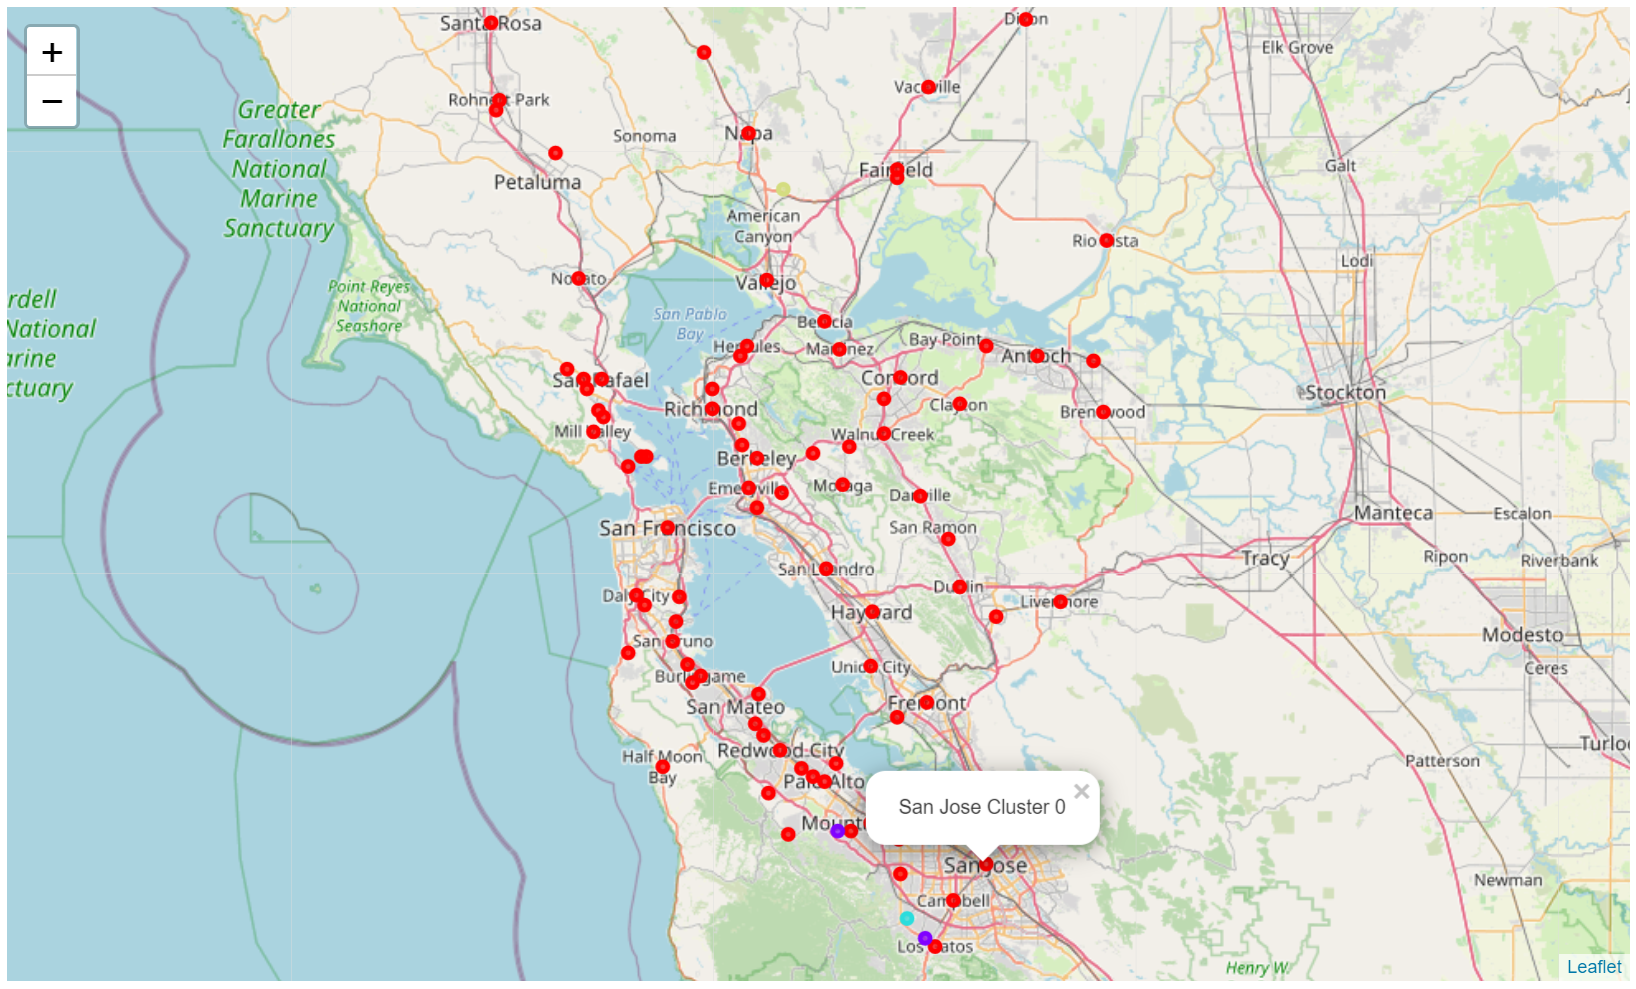

## Step 8: analyze the cluster by listing the most popular venues for each cluster

For each cluster, the most popular 10 venue categories of each neighborhood were put together. The first 10 venue categories were the most popular one of each cluster, from which we probably can tell the difference among clusters. 

- Cluster 0: populous city at least polulous city center, with variety of venues, like restaurant, grocery store, and park, mexican and asain food is populous;
- Cluster 1: less populous city center, with less restaurants;
- Cluster 2: similar with Cluster 1, working out venues standing out;
- Cluster 3: the least populous city type, with winery

In [132]:
df_cluster0=city_merged.loc[city_merged['Cluster Labels'] == 0, city_merged.columns[list(range(2, city_merged.shape[1]-2))]]
cluster0_cate_list=[]
for i in range(0,df_cluster0.shape[0]):
    cluster0_cate_list = cluster0_cate_list + df_cluster0.iloc[i].to_list()
#print(cluster0_cate_list)
#print(len(cluster0_cate_list))
import collections
counter=collections.Counter(cluster0_cate_list)
#print(len(counter))
print(counter.most_common(10))

[('Mexican Restaurant', 46), ('Coffee Shop', 42), ('Sandwich Place', 28), ('Pizza Place', 27), ('Sushi Restaurant', 27), ('Italian Restaurant', 24), ('Chinese Restaurant', 23), ('Park', 23), ('American Restaurant', 23), ('Grocery Store', 19)]


In [133]:
df_cluster1=city_merged.loc[city_merged['Cluster Labels'] == 1, city_merged.columns[list(range(2, city_merged.shape[1]-2))]]
cluster1_cate_list=[]
for i in range(0,df_cluster1.shape[0]):
    cluster1_cate_list = cluster1_cate_list + df_cluster1.iloc[i].to_list()
counter=collections.Counter(cluster1_cate_list)
print(counter.most_common(10))

[('Home Service', 2), ('Yoga Studio', 2), ('Fondue Restaurant', 2), ('Filipino Restaurant', 2), ('Financial or Legal Service', 2), ('Fish & Chips Shop', 2), ('Fish Market', 2), ('Flea Market', 2), ('Flower Shop', 2), ('Music Venue', 1)]


In [134]:
df_cluster2=city_merged.loc[city_merged['Cluster Labels'] == 2, city_merged.columns[list(range(2, city_merged.shape[1]-2))]]
cluster2_cate_list=[]
for i in range(0,df_cluster2.shape[0]):
    cluster2_cate_list = cluster2_cate_list + df_cluster2.iloc[i].to_list()
counter=collections.Counter(cluster2_cate_list)
print(counter.most_common(10))

[('Baseball Field', 1), ('Yoga Studio', 1), ('Garden Center', 1), ('Financial or Legal Service', 1), ('Fish & Chips Shop', 1), ('Fish Market', 1), ('Flea Market', 1), ('Flower Shop', 1), ('Fondue Restaurant', 1), ('Food', 1)]


In [135]:
df_cluster3=city_merged.loc[city_merged['Cluster Labels'] == 3, city_merged.columns[list(range(2, city_merged.shape[1]-2))]]
cluster3_cate_list=[]
for i in range(0,df_cluster3.shape[0]):
    cluster3_cate_list = cluster3_cate_list + df_cluster3.iloc[i].to_list()
counter=collections.Counter(cluster3_cate_list)
print(counter.most_common(10))

[('Winery', 1), ('Yoga Studio', 1), ('Food', 1), ('Filipino Restaurant', 1), ('Financial or Legal Service', 1), ('Fish & Chips Shop', 1), ('Fish Market', 1), ('Flea Market', 1), ('Flower Shop', 1), ('Fondue Restaurant', 1)]
